In [2]:
#!pip install livelossplot
#from livelossplot import PlotLossesKeras

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import cv2

In [ ]:
# G:/ALIENWARE/ALIENWARE_OCT_2020/D/Rahana/KAGGLE/Melanoma/input

In [4]:
#dirname='../input/siim-isic-melanoma-classification/'
dirname='G:/ALIENWARE/ALIENWARE_OCT_2020/D/Rahana/KAGGLE/Melanoma/input/'
train = pd.read_csv(dirname+'train.csv')
test = pd.read_csv(dirname + 'test.csv')
print(train.head())
print(len(train))
print(len(test))
print(train['target'].value_counts())

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
33126
10982
0    32542
1      584
Name: target, dtype: int64


In [5]:
df_0 = train[train['target']==0].sample(3000)
df_1 = train[train['target']==1]
train = pd.concat([df_0, df_1])
train = train.reset_index()
del df_0
del df_1
print(len(train))

3584


In [6]:
def right_size(arr):
    arr = cv2.resize(arr, (256,256))
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return arr

(480, 640, 3)


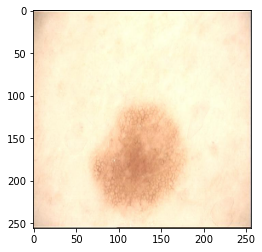

In [7]:
arr = cv2.imread(dirname + 'jpeg/' + 'train/' + train['image_name'].iloc[0] + '.jpg')
plt.imshow(right_size(arr))
print(arr.shape)

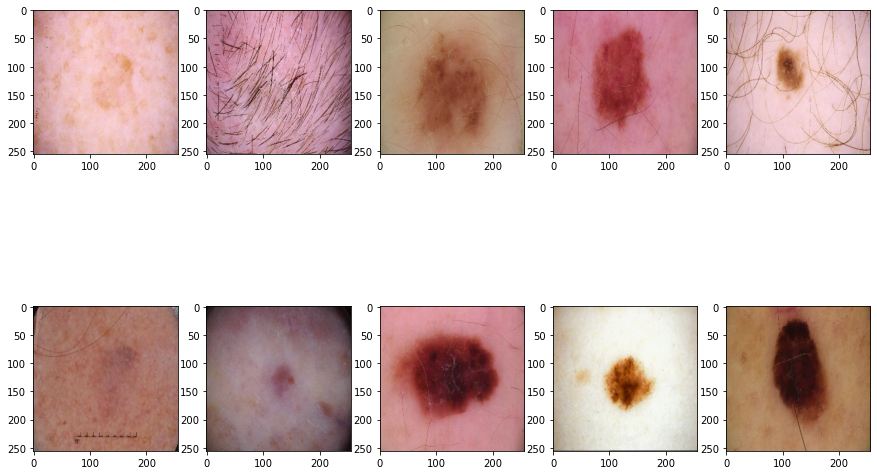

In [8]:
fig = plt.figure(figsize=(15,10))
columns = 5
rows = 2
for i in [0,1]:
    df = train[train['target']==i].sample(5)
    df = list(df['image_name'])
    for j in range(5):
        fig.add_subplot(rows, columns, i*columns + j + 1)
        plt.imshow(right_size(cv2.imread(dirname + 'jpeg/train/' + df[j] + '.jpg')))
    del df

In [9]:
data = []
target = []
for i in range(len(train)):
    data.append(dirname + 'jpeg/train/' + train['image_name'].iloc[i] + '.jpg')
    target.append(train['target'].iloc[i])

test_data = []
for i in range(len(test)):
    test_data.append(dirname + 'jpeg/test/' + test['image_name'].iloc[i] + '.jpg')
test_path = pd.DataFrame(test_data)
test_path.columns = ['images']

In [10]:
train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size = 0.2, random_state = 1)

train = pd.DataFrame(train_X)
train.columns = ['images']
train['target'] = train_Y

val = pd.DataFrame(val_X)
val.columns = ['images']
val['target'] = val_Y

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train, x_col='images', y_col='target', 
                                                   target_size = (256,256), batch_size=10, shuffle=True, class_mode = 'raw')
val_generator = val_datagen.flow_from_dataframe(val, x_col='images', y_col='target', 
                                                   target_size = (256,256), batch_size=10, shuffle=False, class_mode = 'raw')

Found 2867 validated image filenames.
Found 717 validated image filenames.


In [12]:
X_in = layers.Input((256 , 256, 3))

X = layers.Conv2D(80, (6, 6), strides=(2, 2), name='conv1')(X_in)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X = layers.MaxPool2D(pool_size=(3, 3), strides=1, name='max_pool1')(X)

X = layers.Conv2D(160, (6,6), strides=(2, 2), name = 'conv2')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X = layers.MaxPool2D(pool_size = (3,3), strides=1, name='max_pool2')(X)

X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv3')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.MaxPool2D(pool_size = (3,3), strides=1, name='max_pool3')(X)

X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv4')(X1)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv5')(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X1])
X = layers.Activation('relu')(X)

X2 = layers.MaxPool2D(pool_size = (2,2), strides=2, name='max_pool4')(X)

X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv6')(X2)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv7')(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X2])
X = layers.Activation('relu')(X)

X = layers.Flatten()(X)
X = layers.Dense(4096, activation='relu', name='fc1')(X)
X = layers.Dense(1024, activation='relu', name='fc2')(X)
X_out = layers.Dense(1, activation='sigmoid', name='answer')(X)

model = Model(inputs=X_in, outputs=X_out, name='pinnet')

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "pinnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 126, 126, 80) 8720        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 126, 126, 80) 320         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 126, 126, 80) 0           batch_normalization[0][0]        
_____________________________________________________________________________________________

In [14]:
epochs=3
#cb = [PlotLossesKeras()]
history = model.fit_generator(train_generator, steps_per_epoch = train.shape[0]//10, epochs = epochs,
                             validation_data = val_generator, validation_steps = val.shape[0]//10) # callbacks = cb,

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
286/286 [==============================] - 1247s 4s/step - loss: 31.7321 - accuracy: 0.7399 - val_loss: 0.5186 - val_accuracy: 0.8408
Epoch 2/3
286/286 [==============================] - 1217s 4s/step - loss: 1.2843 - accuracy: 0.7788 - val_loss: 0.3873 - val_accuracy: 0.8380
Epoch 3/3
286/286 [==============================] - 1212s 4s/step - loss: 0.4766 - accuracy: 0.8281 - val_loss: 0.4707 - val_accuracy: 0.8408


In [15]:
model.save('pinnet')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pinnet\assets


In [16]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_path, x_col='images', y_col=None, 
                                                   target_size = (256,256), batch_size=10, shuffle=False, class_mode=None)
test_generator.reset()

Found 10982 validated image filenames.


In [17]:
preds = model.predict(test_generator, steps=test.shape[0]//10+1)
ans = np.array(preds)
print(ans.shape)

(10982, 1)


In [18]:
ans=list(ans)
for i in range(len(ans)):
    ans[i]=ans[i][0]

In [19]:
final = {'image_name':list(test['image_name']), 'target':ans }

sub = pd.DataFrame(final, columns=['image_name', 'target'])
print(sub.head())
print(sub.describe())

     image_name    target
0  ISIC_0052060  0.006821
1  ISIC_0052349  0.000264
2  ISIC_0058510  0.000073
3  ISIC_0073313  0.000094
4  ISIC_0073502  0.331543
             target
count  1.098200e+04
mean   9.431515e-02
std    1.251656e-01
min    8.010499e-08
25%    8.403659e-04
50%    3.075908e-02
75%    1.358132e-01
max    9.974215e-01


In [20]:
sub.to_csv('submission.csv', header=True, index=False)